### MNE 라이브러리 튜토리얼 따라해보기!

https://mne.tools/stable/auto_tutorials/intro/10_overview.html#sphx-glr-auto-tutorials-intro-10-overview-py

In [3]:
import numpy as np
import mne
import sklearn

#### Sample data 받아오기
이 경우에는 fif 형식의 파일을 받아오지만 MNE에서는 다른 형식의 파일들도 많이 지원한다!
  
sample data는 audiovisual experiment를 수행하는 대상의 EEG, MEG 데이터로, structural MRI 스캔으로 얻어낸 데이터

In [4]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file C:\Users\NMAIL\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [5]:
print(raw)
print(raw.info)

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.2 MB, data not loaded>
<Info | 14 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>


Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).
Using matplotlib as 2D backend.


c:\Users\NMAIL\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


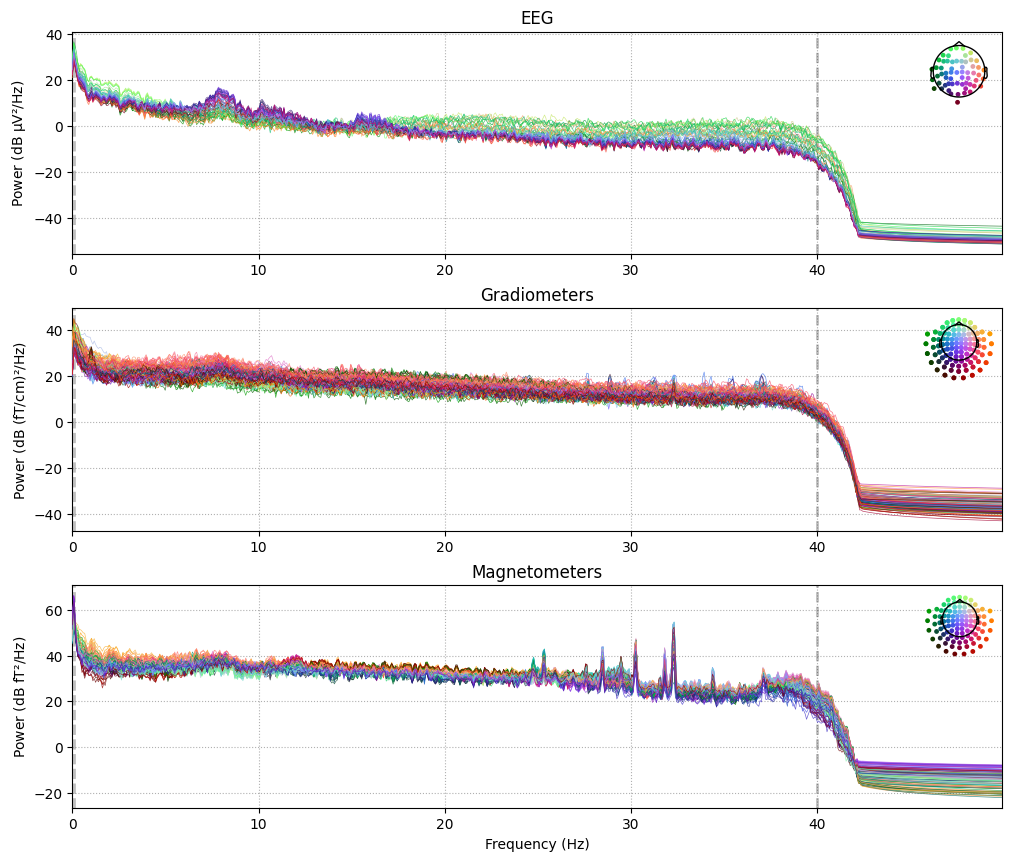

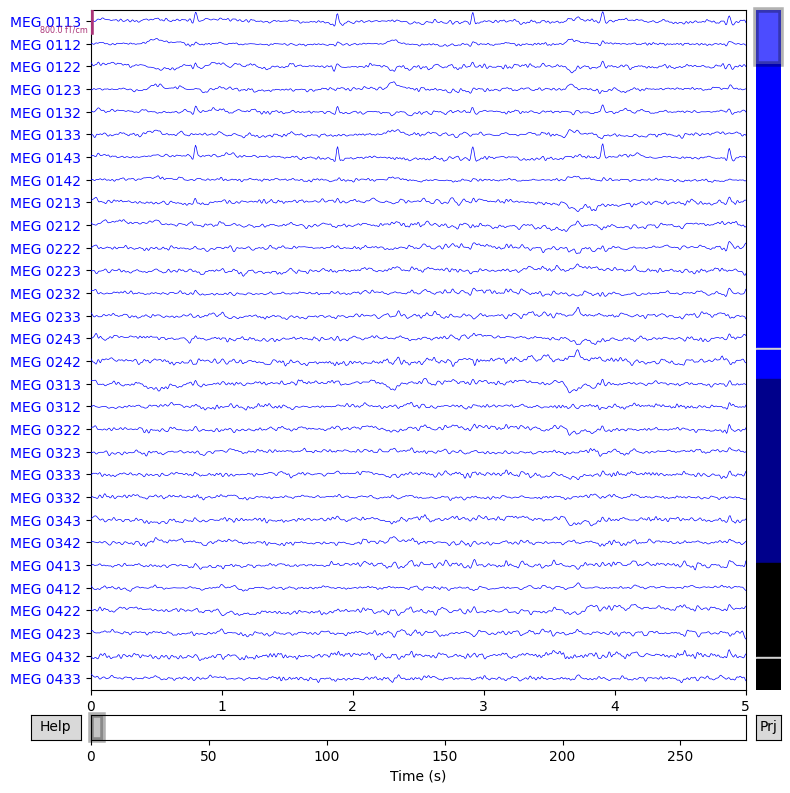

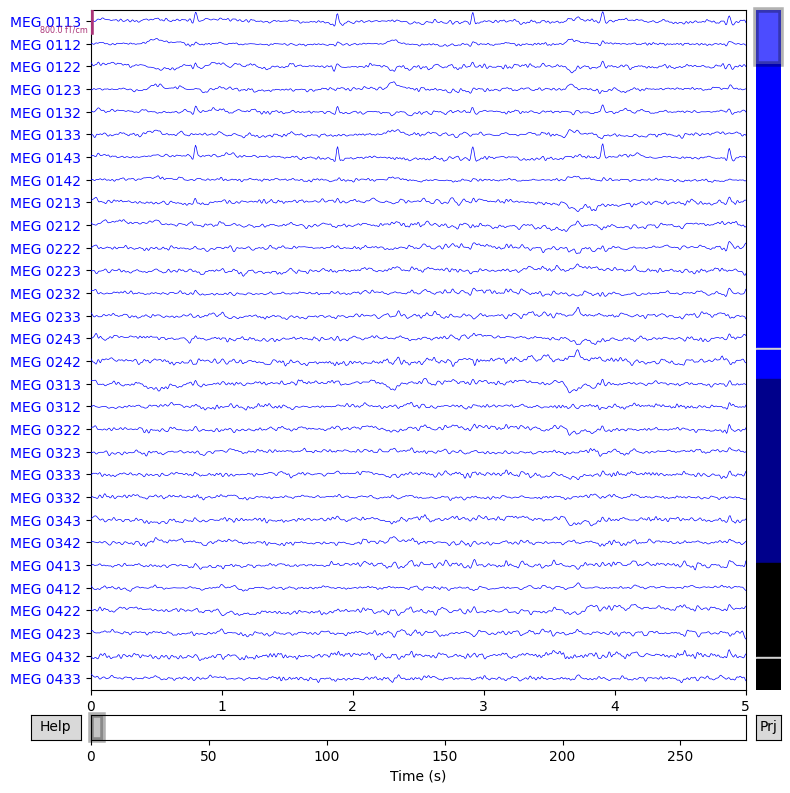

In [6]:
#raw data object는 compute_psd(power spectral density 계산), plot 등의 메서드 지원
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=30)

#### Preprocessing

MNE에서는 다양한 preprocessing 메서드를 제공 (지원하는 메서드는 문서 참조)
예시에서는 ICA(Independent Components Analysis)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.4s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


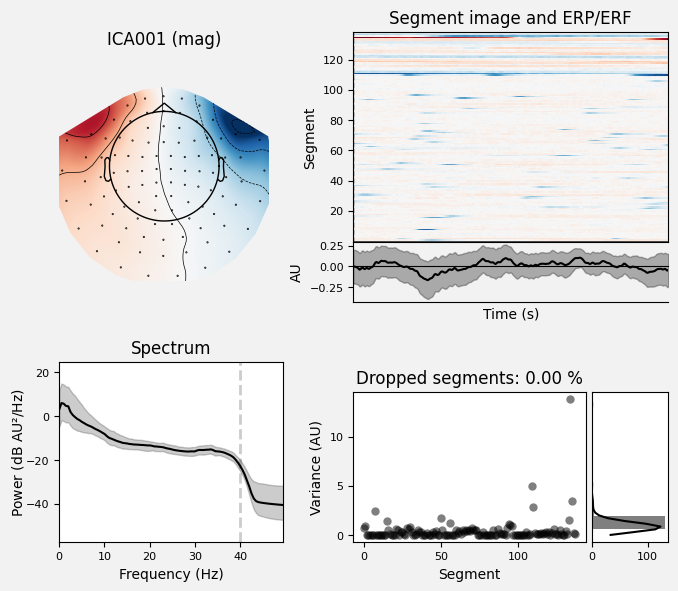

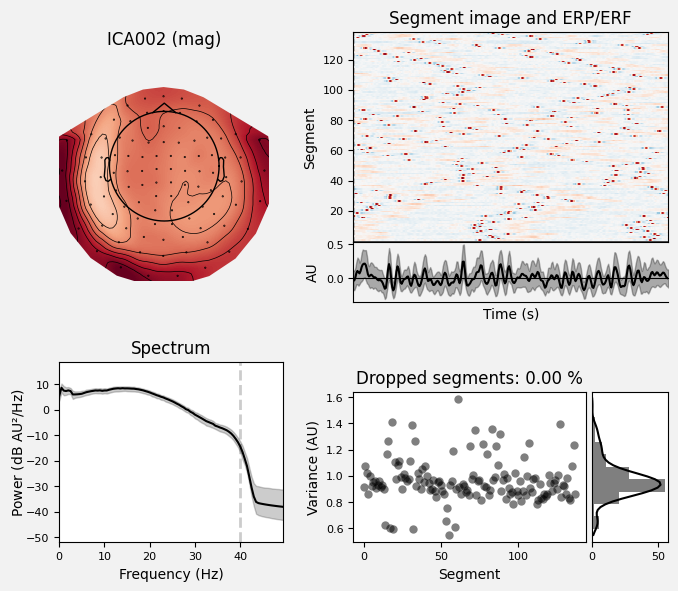

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [7]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

#튜토리얼에는 안 나와 있는데, 사이킷런(sklearn) 패키지 필요

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


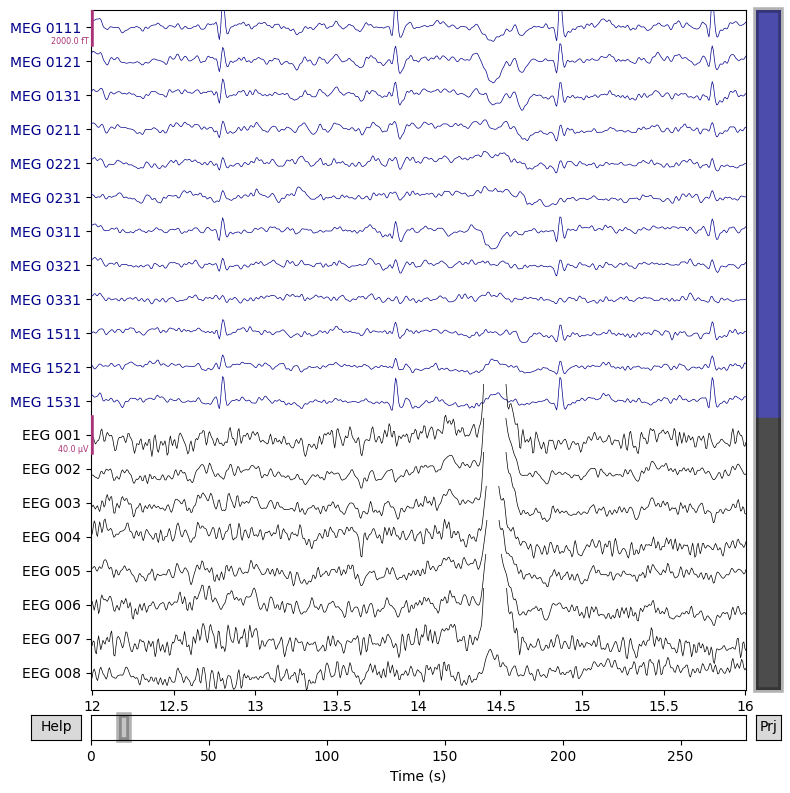

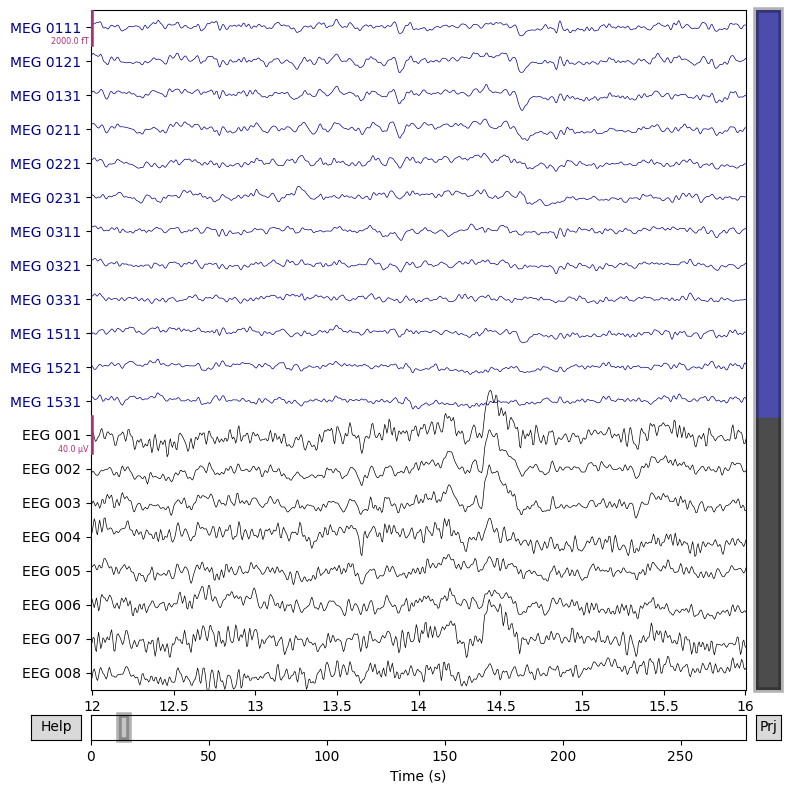

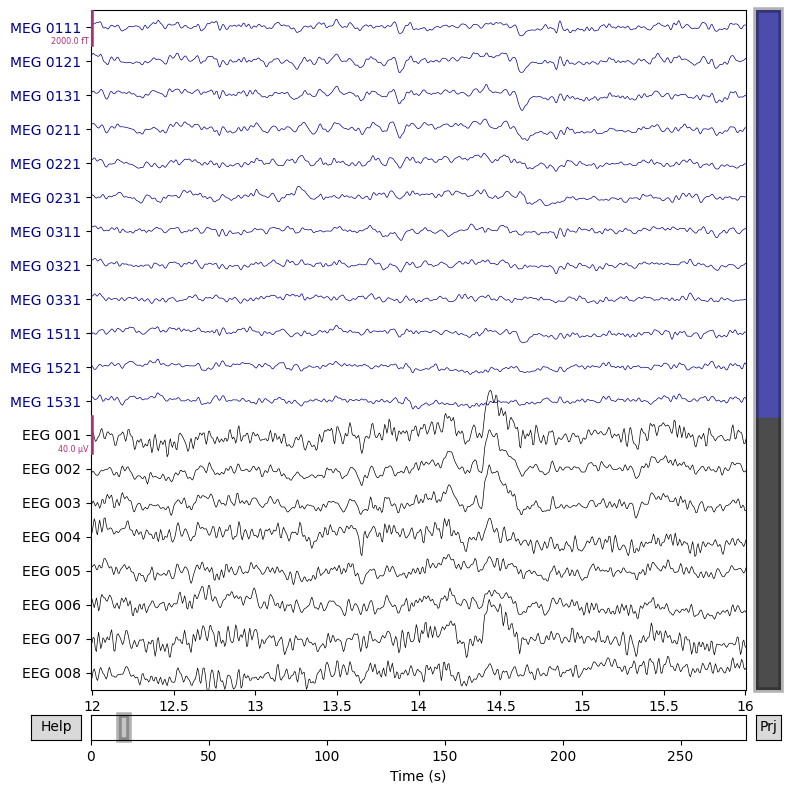

In [8]:
orig_raw = raw.copy() #ICA 적용 전 원래의 original raw data
raw.load_data() #메모리로 로드
ica.apply(raw) #ica apply

# show some frontal channels to clearly illustrate the artifact removal
chs = [
    "MEG 0111",
    "MEG 0121",
    "MEG 0131",
    "MEG 0211",
    "MEG 0221",
    "MEG 0231",
    "MEG 0311",
    "MEG 0321",
    "MEG 0331",
    "MEG 1511",
    "MEG 1521",
    "MEG 1531",
    "EEG 001",
    "EEG 002",
    "EEG 003",
    "EEG 004",
    "EEG 005",
    "EEG 006",
    "EEG 007",
    "EEG 008",
]
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
#original data
orig_raw.plot(order=chan_idxs, start=12, duration=4)
#ICA applied data
raw.plot(order=chan_idxs, start=12, duration=4)


#### Detecting Experimental Events
sample dataset에 포함된 event들을 find_event 메서드로 얻어낸다  
  
이 sample dataset은 stimulus delivery computer에서 전달된 전기 신호를 기록하는 "STIM channel"에서 얻어낸 정보들을 포함하고 있다.   
각각의 STIM 채널의 정보는 하나의 채널로 합쳐지며, 해당 채널의 전압 레벨을 특정 이벤트 유형으로 명확하게 디코딩할 수 있다.   
이 sample data를 기록하는 데 사용했던 시스템(구형 neuromag system)에서는 이 합쳐진 채널의 이름이 STI 014였기 때문에 인자로 STI 014를 넘겨준다.

* STIM channel(or triggal Channel)이란?  
recording 중 experimental event(stimulus onset, stimulus type, participant response(button press))를 encode하는 채널로,  
항상 0 값을 가지다가 어떠한 이벤트가 발생했을 때는 양수 값을 가지게 되는 채널.   
채널 이름에 접두어 'STI'가 붙는 경우가 많음

In [9]:
events = mne.find_events(raw, stim_channel="STI 014")
print(events[:5])  # 일단 맨 앞 5개만


319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


세 개의 열이 있는데, 첫 번째 열은 sample number, 마지막 열은 event ID (가운데 열은 주로 무시됨)
이 sample dataset에서 event ID는 아래와 같이 mapping됨(event dictionary 존재)

1 : auditory stimulus(tone) to the left ear 왼쪽 귀 청각 자극  
2 : auditory stimulus(tone) to the right ear 오른쪽 귀 청각 자극  
3 : visual stimulus(checkerboard) to the left visual field 왼쪽 시각 자극  
4 : visual stimulus(checkerobard) to the right visual field 오른쪽 시각 자극  
5 : smiley face(catch trial)  
6 : subject button press 

In [10]:
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}

#이런 식으로 /을 이용해 key에서 하위 분류를 만들어 주면 처리하기 더 쉬움
#e.g. requesting 'auditory' will select all epochs with event IDs 1 and 2
# requsting 'left' will select all epochs with event IDs 1 and 3

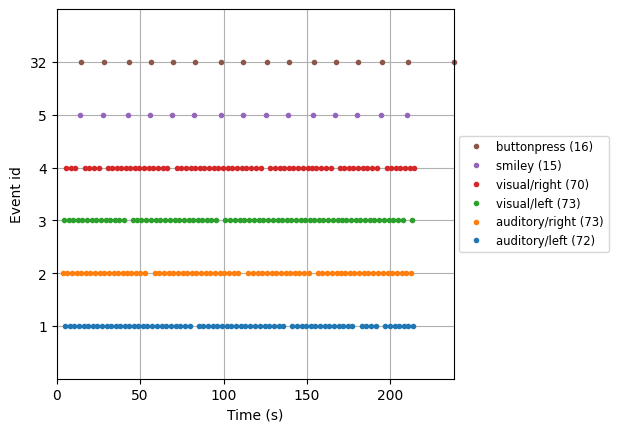

In [11]:
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

#### Epoching continuous data
연속적인 데이터를 epoch 단위로 자르자!  
어떤 기준으로 필요한 정보만 자르고 불필요한 정보는 reject할 것인가?를 정해야 함   
이것도 기준을 적어놓은 rejection dictionary를 만들어서 사용  

In [12]:
reject_criteria = dict(
    mag=4000e-15,  # 4000 fT
    grad=4000e-13,  # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,
)  # 250 µV

그리고 epoch를 자르자  
event_id 파라미터로는 아까 그 event_dict를 넘겨 주고,  
tmin과 tmax(time relative to each event at which to start and end each epoch)를 specify  


In [13]:
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=reject_criteria,
    preload=True,
)

print(epochs)

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped
<Epochs | 309 events (all good), -0.2 – 0.499 s (baseline -0.2 – 0 s), ~97.2 MB, data loaded,
 'auditory/left': 68
 'auditory/right': 70
 'visual/left': 73
 'visual/right': 68
 'smiley': 14
 '

auditory 반응과 visual 반응을 비교하기 위해 left/right를 각각 합치자  
이 때 left나 right로의 bias를 없애기 위해 equalize_event_counts 메서드를 이용함  
  
두 상태(left/right)중에 더 적은 개수만큼, 가장 좋은 epoch들만 남겨놓기  
  
위의 셀에서는 left와 right가 개수가 서로 달랐는데, auditory/left에 맞게 auditory/right에서 2개, visual/right에 맞게 visual/left에서 5개를 삭제하여 개수를 맞춘 것을 확인할 수 있다

In [14]:
conds_we_care_about = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs["auditory"]
vis_epochs = epochs["visual"]
del raw, epochs  # free up memory

print(aud_epochs)
print(vis_epochs)

Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275
<Epochs | 136 events (all good), -0.2 – 0.499 s (baseline -0.2 – 0 s), ~44.5 MB, data loaded,
 'auditory/left': 68
 'auditory/right': 68>
<Epochs | 136 events (all good), -0.2 – 0.499 s (baseline -0.2 – 0 s), ~44.5 MB, data loaded,
 'visual/left': 68
 'visual/right': 68>


Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


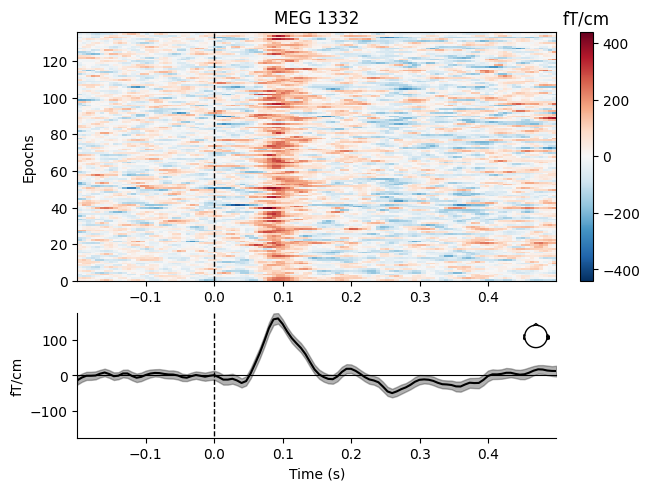

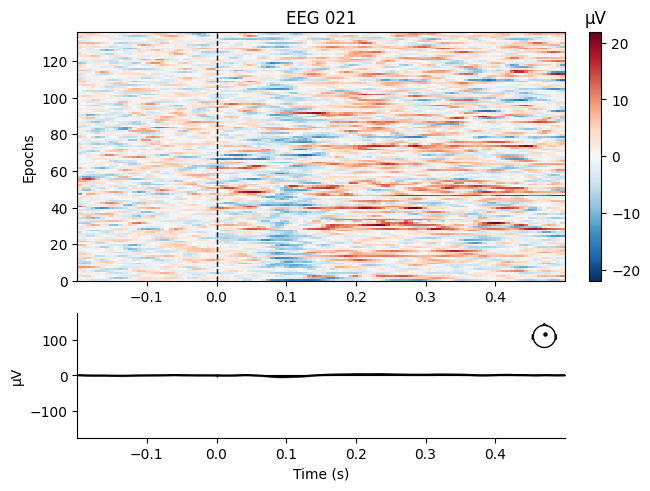

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [15]:
#raw 객체와 비슷하게 epochs도 plot과 같은 빌트인 메서드를 제공함
#image map의 한 행(row)이 각 epoch, 색상이 signal magnitude
aud_epochs.plot_image(picks=["MEG 1332", "EEG 021"])

#### Time-Frequency Analysis
mne.time_frequency submodule은 time-frequency 분석을 할 수 있는 다양한 알고리즘을 제공함

아래 예시에서는 Morlet wavelet을 이용하여 서로 다른 주파수와 시간에서 유도된 전력(power)를 색상으로 계산(auditory epochs에서)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    6.3s


No baseline correction applied


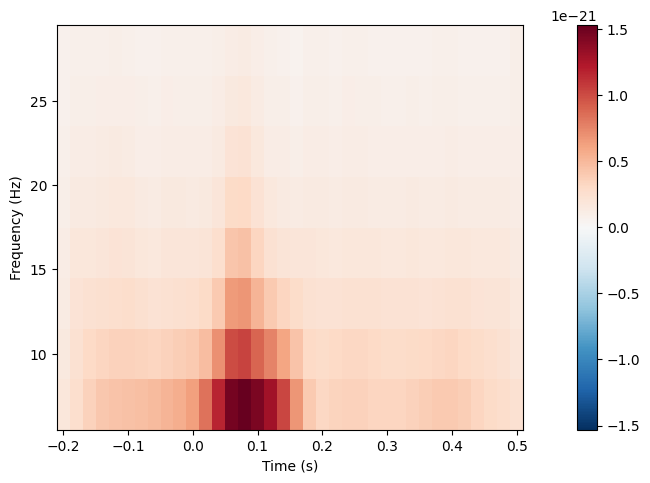

[<Figure size 640x480 with 2 Axes>]

In [16]:
frequencies = np.arange(7, 30, 3)
power = aud_epochs.compute_tfr(
    "morlet", n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True
)
power.plot(["MEG 1332"])

#### Estimating evoked responses

Multiple channel types selected, returning one figure per type.
combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


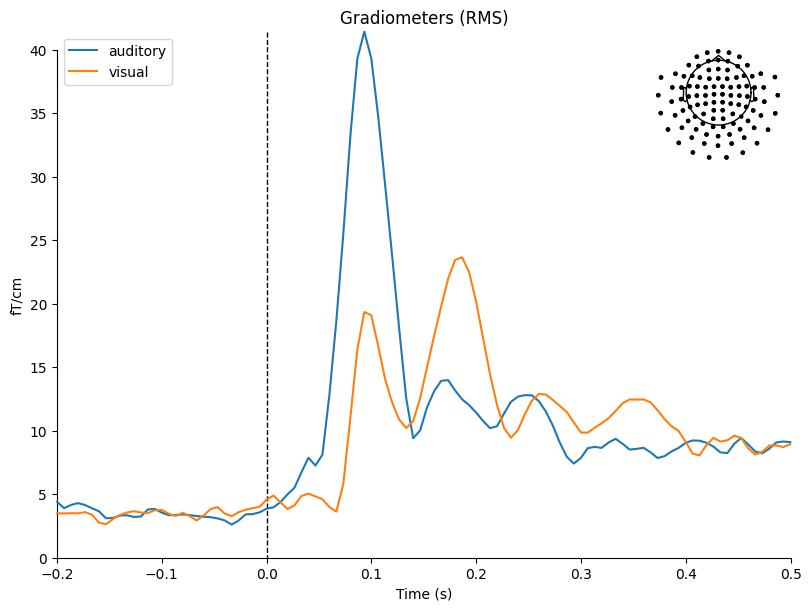

combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


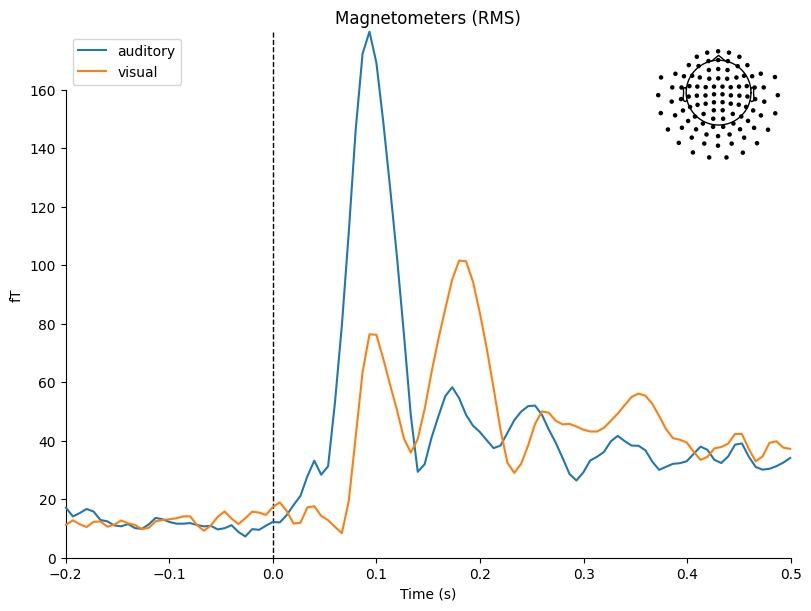

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


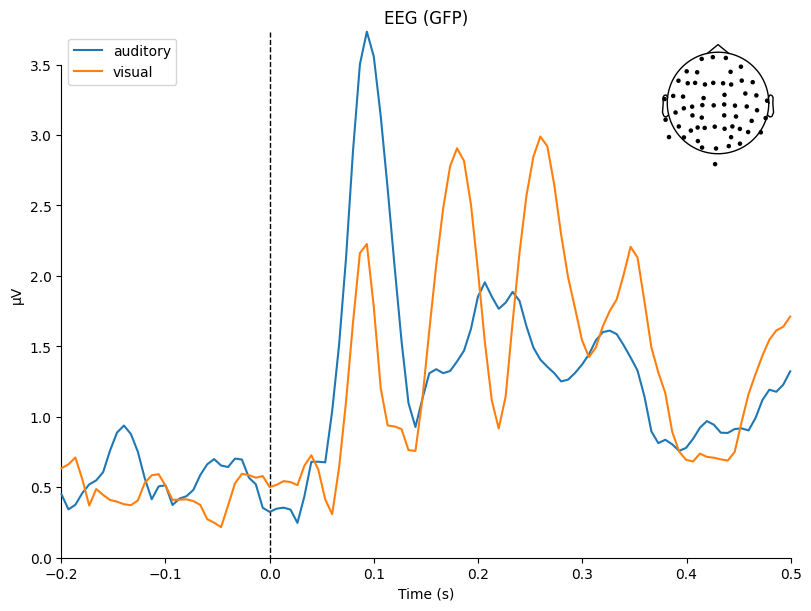

[<Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>]

In [17]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(
    dict(auditory=aud_evoked, visual=vis_evoked),
    legend="upper left",
    show_sensors="upper right",
)

Projections have already been applied. Setting proj attribute to True.


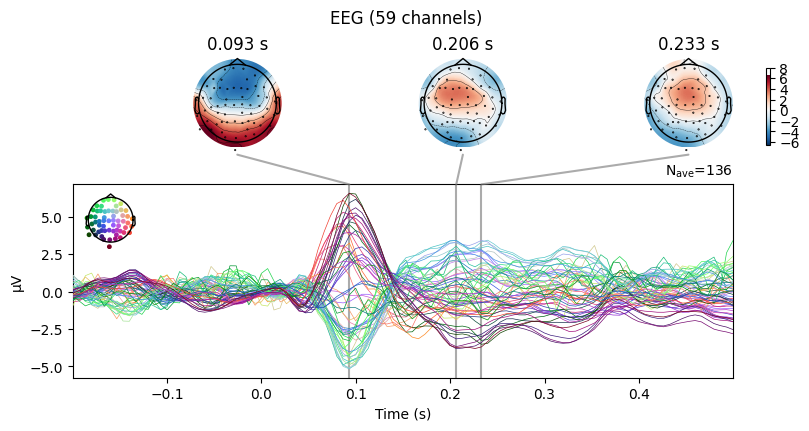

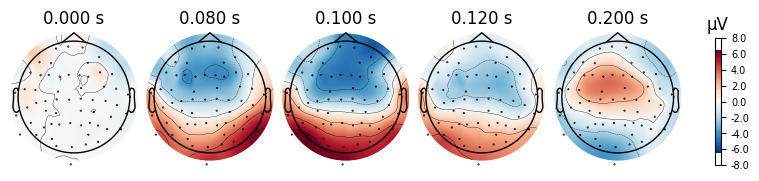

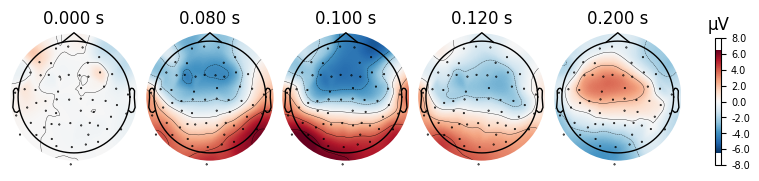

In [18]:
aud_evoked.plot_joint(picks="eeg")
aud_evoked.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")

#### Inverse modeling

In [19]:
# load inverse operator
inverse_operator_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis-meg-oct-6-meg-inv.fif"
)
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)
# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.0
lambda2 = 1.0 / snr**2
# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(
    vis_evoked, inv_operator, lambda2=lambda2, method="MNE"
)  # or dSPM, sLORETA, eLORETA

Reading inverse operator decomposition from C:\Users\NMAIL\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing 

이 아래는 계속 에러가 뜨네요...

In [21]:
# path to subjects' MRI files
subjects_dir = sample_data_folder / "subjects"
# plot the STC
stc.plot(
    initial_time=0.1, hemi="split", views=["lat", "med"], subjects_dir=subjects_dir
)

Using control points [8.61922423e-11 1.06837855e-10 4.49139511e-10]


ValueError: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline', 'module://matplotlib_inline.backend_inline']